## import package and data

In [1]:
# Install package first
# We use uv for faster installation

# Google Colab is setting some uv-related environment variables, that seem to have broken with the a Colab update.
# The Colab team is tracking this internally (googlecolab/colabtools#5237).
# https://github.com/googlecolab/colabtools/issues/5237#issuecomment-2786440777
import os
os.environ["UV_CONSTRAINT"] = os.environ["UV_BUILD_CONSTRAINT"] = ""  # add this line to solve the uv related issue

!pip install uv
!uv pip install -q autogluon.timeseries --system
!uv pip uninstall -q torchaudio torchvision torchtext --system # fix incompatible package versions on Colab
!uv pip uninstall transformers
# !uv pip install -q torch==2.3.0 torchvision==0.18.0 --index-url https://download.pytorch.org/whl/cu118
!uv pip install -q transformers==4.44.2

## if there seems to be inconsistency due to numpy & pandas versions, do the following
# !uv pip uninstall pandas numpy
# !uv pip install -q --force-reinstall numpy==1.26.4 --system
# !uv pip install -q --force-reinstall pandas==2.2.2 --system
## You may need to restart colab kernel

Using Python 3.11.12 environment at: /usr
Uninstalled 1 package in 139ms
 - transformers==4.44.2


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

In [3]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [4]:
from scipy import signal
import math
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from scipy.signal import welch
from statsmodels.tsa.stattools import adfuller
import itertools
warnings.filterwarnings("ignore")

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
cd drive/MyDrive/Online Retail/Chronos on Previous Categories

/content/drive/.shortcut-targets-by-id/1bsuuXsN9f_3_uPMxfoq1e9R2u7sIHJwZ/Online Retail/Chronos on Previous Categories


In [7]:
ls

 AutogluonModels/
 categories_merged.csv
 Chronos_Fashion.ipynb
 Chronos_Home.ipynb
 Chronos_Kitchen.ipynb
 Chronos_Lights.ipynb
'Chronos Results on Previous Categories.gsheet'
 Chronos_Toys.ipynb
 fashion_accessories.csv
 home_storage.csv
 kitchen_dining.csv
 lights_decorations.csv
 onlineRetail_4i_categorization.ipynb
 toys_gifts.csv


In [8]:
file_path = "home_storage.csv"
df = pd.read_csv(file_path)
print(df.describe())
df.head()

            Quantity          Price          Sales
count  329087.000000  329087.000000  329087.000000
mean        9.167162       5.496983      22.250108
std        53.684194      87.670143     110.811188
min         1.000000       0.001000       0.001000
25%         1.000000       1.630000       4.300000
50%         3.000000       2.550000      11.620000
75%         9.000000       5.750000      19.500000
max     10000.000000   25111.090000   25111.090000


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Country,Sales,Category
0,489434,22041,"record frame 7"" single size",48,2009-12-01 07:45:00,2.10,United Kingdom,100.8,Home & Storage
1,489434,21232,strawberry ceramic trinket box,24,2009-12-01 07:45:00,1.25,United Kingdom,30.0,Home & Storage
2,489434,22064,pink doughnut trinket pot,24,2009-12-01 07:45:00,1.65,United Kingdom,39.6,Home & Storage
3,489434,21523,fancy font home sweet home doormat,10,2009-12-01 07:45:00,5.95,United Kingdom,59.5,Home & Storage
4,489436,22194,black diner wall clock,2,2009-12-01 09:06:00,8.50,United Kingdom,17.0,Home & Storage


In [9]:
# Aggregate total sales per day across all categories
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])
df_all = df.copy()
df_all = df_all.set_index('InvoiceDate')

total_sales = df_all['Sales'].resample('D').sum().reset_index()
total_sales.columns = ['ds', 'y']
total_sales['ds'] = pd.to_datetime(total_sales['ds'])
total_sales['y'] = total_sales['y'].astype(float)
print(total_sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739 entries, 0 to 738
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      739 non-null    datetime64[ns]
 1   y       739 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.7 KB
None


In [10]:
total_sales

,ds,y
0,2009-12-01,18113.53
1,2009-12-02,16404.80
2,2009-12-03,19692.95
3,2009-12-04,13914.68
4,2009-12-05,3028.10
...,...,...
734,2011-12-05,24405.03
735,2011-12-06,21257.70
736,2011-12-07,29577.22
737,2011-12-08,33011.11


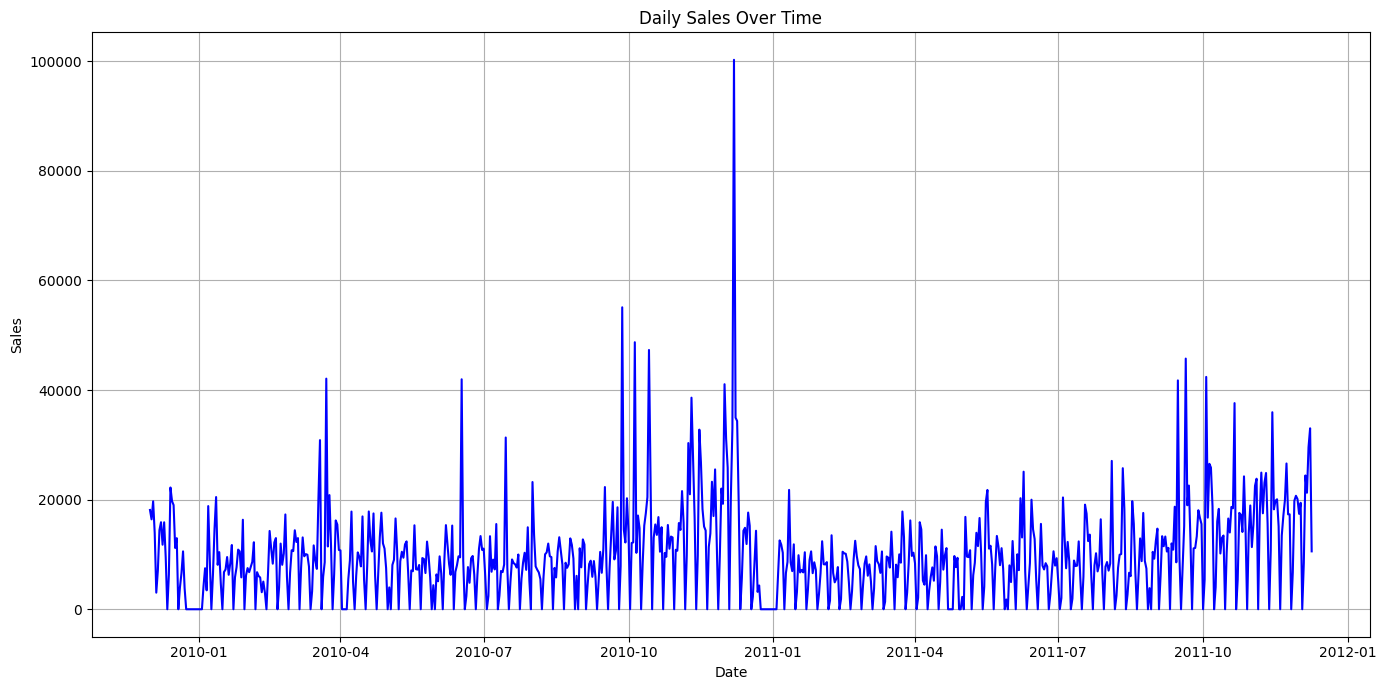

In [11]:
plt.figure(figsize=(14, 7))
plt.plot(total_sales['ds'], total_sales['y'], color='blue', linewidth=1.5)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Daily Sales Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
# change data format to be used in Chronos
total_sales_chronos = total_sales.rename(columns={'ds': 'timestamp', 'y': 'target'})
total_sales_chronos['item_id'] = 1
print(total_sales_chronos.head())

   timestamp    target  item_id
0 2009-12-01  18113.53        1
1 2009-12-02  16404.80        1
2 2009-12-03  19692.95        1
3 2009-12-04  13914.68        1
4 2009-12-05   3028.10        1


In [13]:
total_sales_chronos = TimeSeriesDataFrame.from_data_frame(total_sales_chronos)
print(total_sales_chronos.head())
total_sales_chronos.describe()

                      target
item_id timestamp           
1       2009-12-01  18113.53
        2009-12-02  16404.80
        2009-12-03  19692.95
        2009-12-04  13914.68
        2009-12-05   3028.10


,target
count,739.000000
mean,9908.283069
std,8771.023389
min,0.000000
25%,5032.190000
50%,8662.860000
75%,13320.630000
max,100244.120000


## Chronos zero-shot model

### Chronos zero-shot bolt_tiny:

In [ ]:
prediction_length = int(len(total_sales_chronos)*0.2)
train_data, test_data = total_sales_chronos.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length, freq="D").fit(
    train_data, presets="bolt_tiny",
)

Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/ForecastFrontiers/Online Retail/Chronos on Previous Categories/AutogluonModels/ag-20250424_025928'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
GPU Count:          1
Memory Avail:       10.08 GB / 12.67 GB (79.5%)
Disk Space Avail:   66.52 GB / 112.64 GB (59.1%)
Setting presets to: bolt_tiny

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'D',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_tiny'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 147,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'targ

Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_tiny]


model.safetensors:   0%|          | 0.00/34.6M [00:00<?, ?B/s]

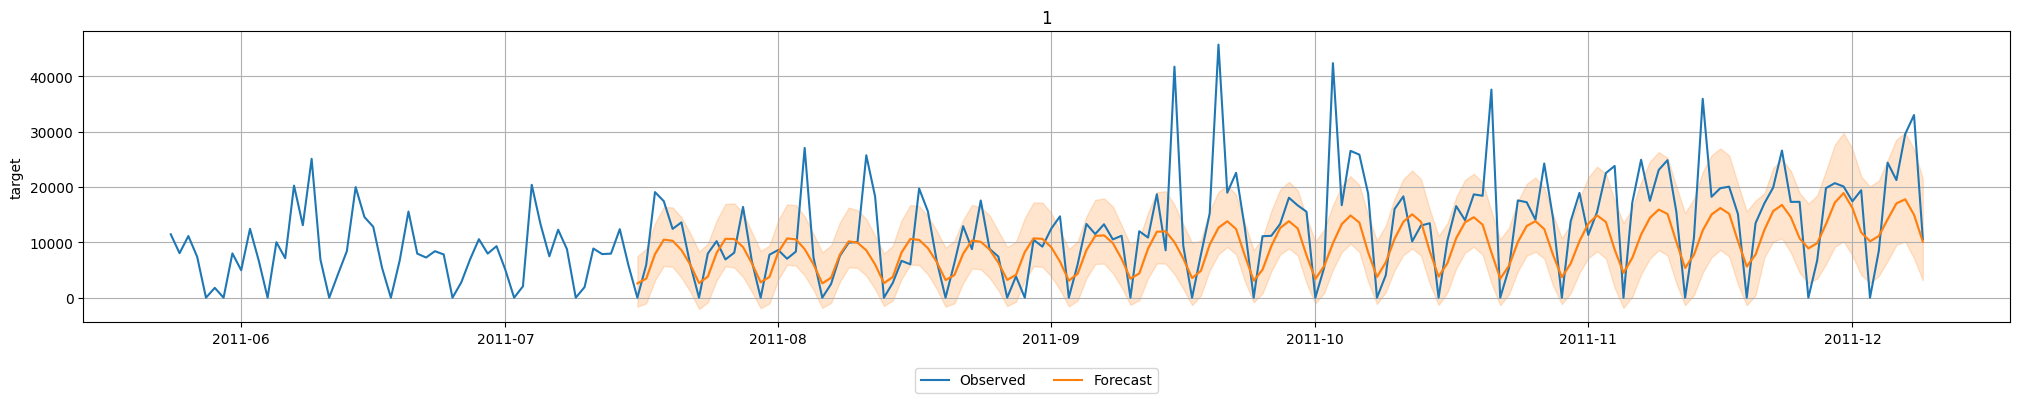

In [ ]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=total_sales_chronos,
    predictions=predictions,
    item_ids=total_sales_chronos.item_ids[:],
    max_history_length=200,
);

In [ ]:
# print(predictions.shape)
# predictions.head()

(147, 10)


mean          0.1          0.2          0.3  \
item_id timestamp                                                         
1       2011-07-16   2585.214355 -1625.126953  -254.636719   767.252930   
        2011-07-17   3454.417969 -1024.400391   448.810547  1549.470215   
        2011-07-18   7901.343750  3149.796387  4738.586426  5904.261719   
        2011-07-19  10496.787109  5738.105469  7326.448242  8479.253906   
        2011-07-20  10290.584961  5581.843750  7115.541504  8268.905273   

                            0.4           0.5           0.6           0.7  \
item_id timestamp                                                           
1       2011-07-16  1697.764160   2585.214355   3479.603027   4489.621582   
        2011-07-17  2528.041016   3454.417969   4413.986816   5512.508789   
        2011-07-18  6927.711426   7901.343750   8879.111328   9987.984375   
        2011-07-19  9505.136719  10496.787109  11540.244141  12727.036133   
        2011-07-20  9301.461914  10290.584961  11346.410156  12513.140625   

                             0.8           0.9  
item_id timestamp                               
1       2011-07-16   5687.638672   7487.030762  
        2011-07-17   6854.416016   8840.911133  
        2011-07-18  11376.433594  13447.220703  
        2011-07-19  14178.701172  16401.046875  
        2011-07-20  14007.161133  16315.602539

In [ ]:
predictor.leaderboard(test_data, extra_metrics=['WQL','MAE', 'MSE','RMSE','MAPE'])

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order,WQL,MAE,MSE,RMSE,MAPE
0,Chronos[bolt_tiny],-0.338594,None,2.98791,None,0.044699,1,-0.338594,-5606.557291,-6.692448e+07,-8180.738333,-0.329582


In [ ]:
# test_data_pd = test_data.reset_index().set_index('timestamp')['target']
# # split test set into 3 equal regions

# def mape(y_true, y_pred):
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# def three_split_plot(predictions, subtitle = ""):

#     test_predict = predictions.reset_index().set_index('timestamp')['mean']
#     test_split = np.array_split(test_predict.index, 3)

#     mape_results = []

#     for i, period in enumerate(test_split):
#         mape_period = mape(test_data_pd.loc[period], test_predict.loc[period])
#         mape_results.append(mape_period)
#         print(f"Overall MAPE for Test Period {i+1}: {mape_period:.2f}%")

#     error_df = []
#     for i, period in enumerate(test_split):
#         period_error = test_data_pd.loc[period] - test_predict.loc[period]
#         error_df.append(pd.DataFrame({'Error': period_error, 'Test Period': f"Overall Period {i+1}"}))

#     error_df = pd.concat(error_df)

#     if subtitle: plt.suptitle(subtitle, fontsize=12)

#     plt.figure(figsize=(8,5))
#     sns.boxplot(x="Test Period", y="Error", data=error_df)
#     plt.title(subtitle + ": Overall Error Distribution Across Test Periods")
#     plt.xlabel("Test Period (Overall)")
#     plt.ylabel("Prediction Error")
#     plt.grid()
#     plt.show()

# three_split_plot(predictions, 'bolt_tiny Zero-shot')

### Chronos zero-shot bolt_mini:

In [ ]:
prediction_length = int(len(total_sales_chronos)*0.2)
train_data, test_data = total_sales_chronos.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length, freq="D").fit(
    train_data, presets="bolt_mini",
)

Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/ForecastFrontiers/Online Retail/Chronos on Previous Categories/AutogluonModels/ag-20250424_030030'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
GPU Count:          1
Memory Avail:       9.85 GB / 12.67 GB (77.7%)
Disk Space Avail:   66.49 GB / 112.64 GB (59.0%)
Setting presets to: bolt_mini

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'D',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 147,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'targe

Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_mini]


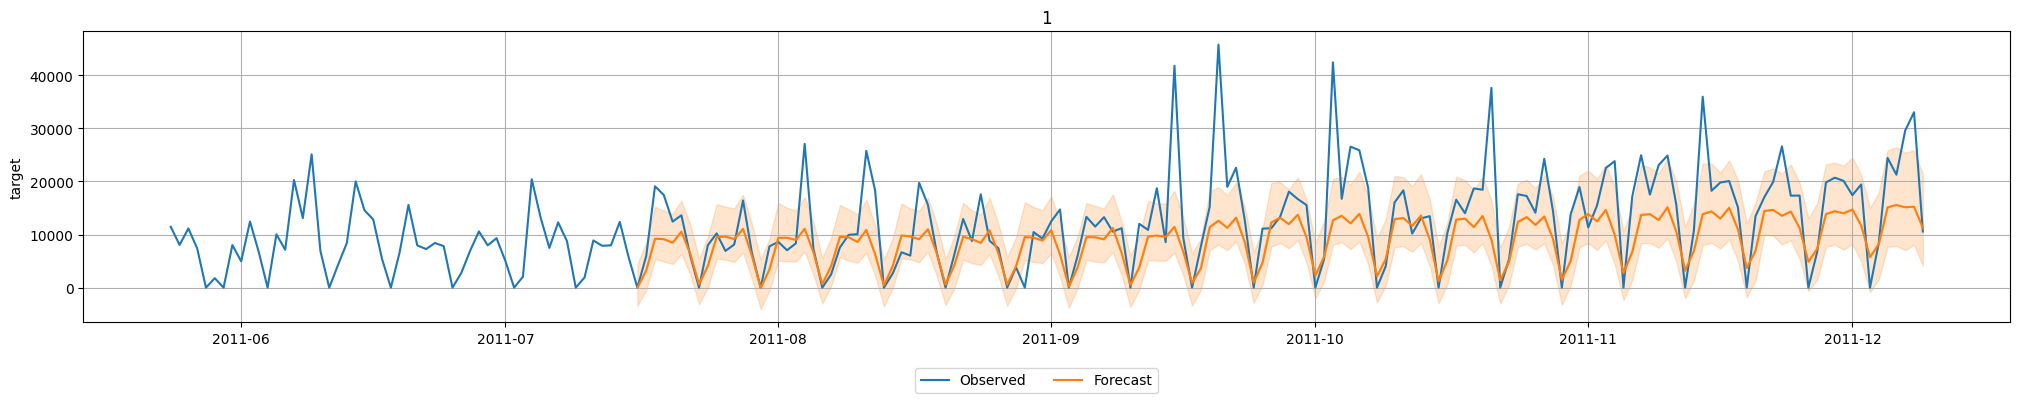

In [ ]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=total_sales_chronos,
    predictions=predictions,
    item_ids=total_sales_chronos.item_ids[:],
    max_history_length=200,
);

In [ ]:
# print(predictions.shape)
# predictions.head()

(147, 10)


mean          0.1          0.2          0.3  \
item_id timestamp                                                        
1       2011-07-16     7.275391 -3402.474609 -2315.098633 -1451.541016   
        2011-07-17  3239.093262  -520.814453   665.747070  1577.068848   
        2011-07-18  9220.130859  5385.019043  6537.218262  7466.166992   
        2011-07-19  9128.266602  4960.171387  6316.053711  7340.941895   
        2011-07-20  8480.884766  4464.352051  5745.629395  6740.759766   

                            0.4          0.5           0.6           0.7  \
item_id timestamp                                                          
1       2011-07-16  -701.361328     7.275391    804.260742   1699.179199   
        2011-07-17  2381.083496  3239.093262   4096.337891   5102.314941   
        2011-07-18  8343.059570  9220.130859  10173.382812  11360.849609   
        2011-07-19  8249.280273  9128.266602  10055.409180  11142.091797   
        2011-07-20  7611.583984  8480.884766   9403.201172  10476.721680   

                             0.8           0.9  
item_id timestamp                               
1       2011-07-16   2781.337891   4490.053223  
        2011-07-17   6406.713867   8429.801758  
        2011-07-18  12910.958008  15231.538086  
        2011-07-19  12440.193359  14512.152344  
        2011-07-20  11764.337891  13864.623047

In [ ]:
predictor.leaderboard(test_data, extra_metrics=['WQL','MAE', 'MSE','RMSE','MAPE'])

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order,WQL,MAE,MSE,RMSE,MAPE
0,Chronos[bolt_mini],-0.318042,None,0.702639,None,0.085108,1,-0.318042,-5217.993914,-6.189950e+07,-7867.6237,-0.32249


In [ ]:
# test_data_pd = test_data.reset_index().set_index('timestamp')['target']
# # split test set into 3 equal regions

# three_split_plot(predictions, 'bolt_mini Zero-shot')

### Chronos zero-shot bolt_small:

In [ ]:
prediction_length = int(len(total_sales_chronos)*0.2)
train_data, test_data = total_sales_chronos.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length, freq="D").fit(
    train_data, presets="bolt_small",
)

Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/ForecastFrontiers/Online Retail/Chronos on Previous Categories/AutogluonModels/ag-20250424_030104'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
GPU Count:          1
Memory Avail:       9.82 GB / 12.67 GB (77.5%)
Disk Space Avail:   66.49 GB / 112.64 GB (59.0%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'D',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 147,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'tar

In [ ]:
# print(train_data.describe())
# print(train_data.head())
# print(test_data.describe())
# print(test_data.head())

              target
count     592.000000
mean    18705.547770
std     15508.013226
min         0.000000
25%      8639.810000
50%     17947.565000
75%     24901.675000
max    131921.040000
                      target
item_id timestamp           
1       2009-12-01  43548.81
        2009-12-02  55576.94
        2009-12-03  51673.62
        2009-12-04  28850.91
        2009-12-05   5071.30
              target
count     739.000000
mean    20564.158742
std     16772.331829
min         0.000000
25%      9908.045000
50%     18794.370000
75%     27374.050000
max    131921.040000
                      target
item_id timestamp           
1       2009-12-01  43548.81
        2009-12-02  55576.94
        2009-12-03  51673.62
        2009-12-04  28850.91
        2009-12-05   5071.30


Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/191M [00:00<?, ?B/s]

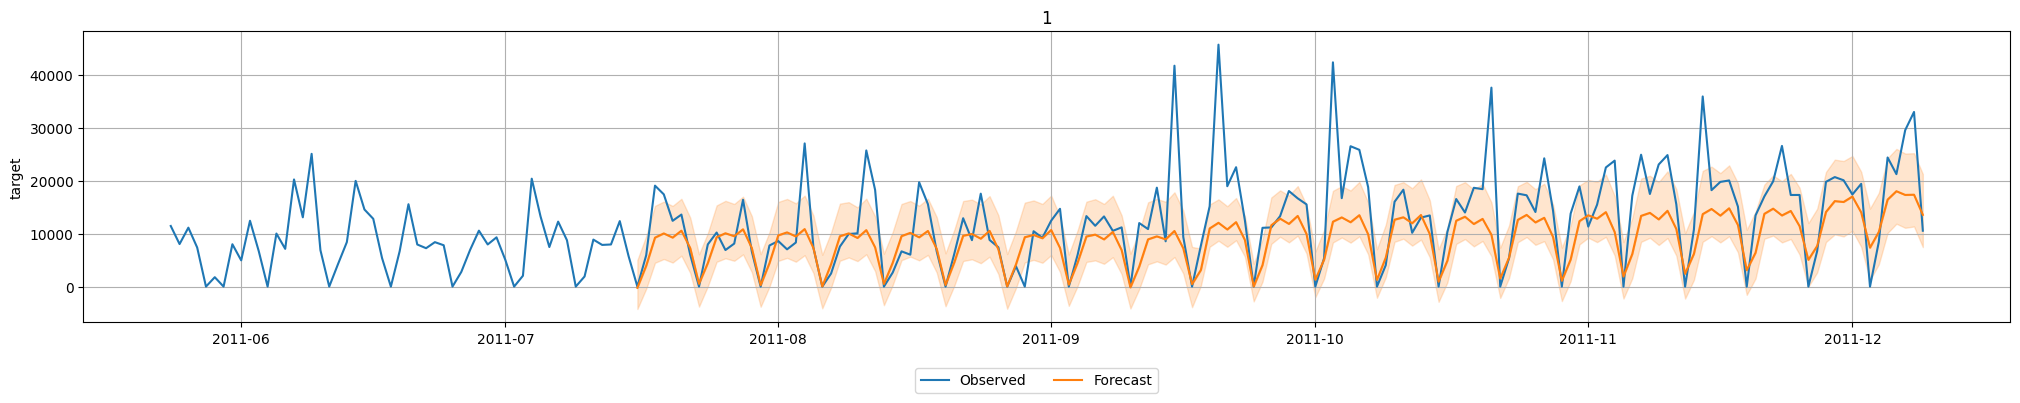

In [ ]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=total_sales_chronos,
    predictions=predictions,
    item_ids=total_sales_chronos.item_ids[:],
    max_history_length=200,
);

In [ ]:
# print(predictions.shape)
# predictions.head()

(147, 10)


mean          0.1          0.2          0.3  \
item_id timestamp                                                         
1       2011-07-16   -226.216797 -4234.203125 -2961.875977 -1954.993164   
        2011-07-17   3934.906738  -404.609375   991.543945  2094.757324   
        2011-07-18   9254.682617  4506.294434  6091.218750  7240.294922   
        2011-07-19  10053.748047  5214.202637  6825.684082  8016.612305   
        2011-07-20   9266.415039  4545.642578  6123.747070  7266.593262   

                            0.4           0.5           0.6           0.7  \
item_id timestamp                                                           
1       2011-07-16 -1093.594727   -226.216797    661.475586   1672.724121   
        2011-07-17  3043.562012   3934.906738   4896.232910   5969.292969   
        2011-07-18  8287.328125   9254.682617  10279.045898  11465.253906   
        2011-07-19  9054.549805  10053.748047  11077.009766  12276.523438   
        2011-07-20  8297.674805   9266.415039  10274.783203  11451.774414   

                             0.8           0.9  
item_id timestamp                               
1       2011-07-16   2953.420410   5026.133789  
        2011-07-17   7327.059570   9556.995117  
        2011-07-18  12913.459961  15261.820312  
        2011-07-19  13757.742188  16069.840820  
        2011-07-20  12894.128906  15246.873047

In [ ]:
predictor.leaderboard(test_data, extra_metrics=['WQL','MAE', 'MSE','RMSE','MAPE'])

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order,WQL,MAE,MSE,RMSE,MAPE
0,Chronos[bolt_small],-0.318185,None,1.772698,None,0.042973,1,-0.318185,-5094.798274,-6.091623e+07,-7804.885249,-0.320139


In [ ]:
# test_data_pd = test_data.reset_index().set_index('timestamp')['target']
# # split test set into 3 equal regions

# def mape(y_true, y_pred):
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# def three_split_plot(predictions, subtitle = ""):

#     test_predict = predictions.reset_index().set_index('timestamp')['mean']
#     test_split = np.array_split(test_predict.index, 3)

#     mape_results = []

#     for i, period in enumerate(test_split):
#         mape_period = mape(test_data_pd.loc[period], test_predict.loc[period])
#         mape_results.append(mape_period)
#         print(f"Overall MAPE for Test Period {i+1}: {mape_period:.2f}%")

#     error_df = []
#     for i, period in enumerate(test_split):
#         period_error = test_data_pd.loc[period] - test_predict.loc[period]
#         error_df.append(pd.DataFrame({'Error': period_error, 'Test Period': f"Overall Period {i+1}"}))

#     error_df = pd.concat(error_df)

#     if subtitle: plt.suptitle(subtitle, fontsize=12)

#     plt.figure(figsize=(8,5))
#     sns.boxplot(x="Test Period", y="Error", data=error_df)
#     plt.title(subtitle + ": Overall Error Distribution Across Test Periods")
#     plt.xlabel("Test Period (Overall)")
#     plt.ylabel("Prediction Error")
#     plt.grid()
#     plt.show()

# three_split_plot(predictions, 'bolt_small Zero-shot')

### Chronos zero-shot bolt_base:

In [ ]:
prediction_length = int(len(total_sales_chronos)*0.2)
train_data, test_data = total_sales_chronos.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length, freq="D").fit(
    train_data, presets="bolt_base",
)

Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/ForecastFrontiers/Online Retail/Chronos on Previous Categories/AutogluonModels/ag-20250424_030134'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
GPU Count:          1
Memory Avail:       9.79 GB / 12.67 GB (77.2%)
Disk Space Avail:   66.32 GB / 112.64 GB (58.9%)
Setting presets to: bolt_base

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'D',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 147,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'targe

Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]


config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/821M [00:00<?, ?B/s]

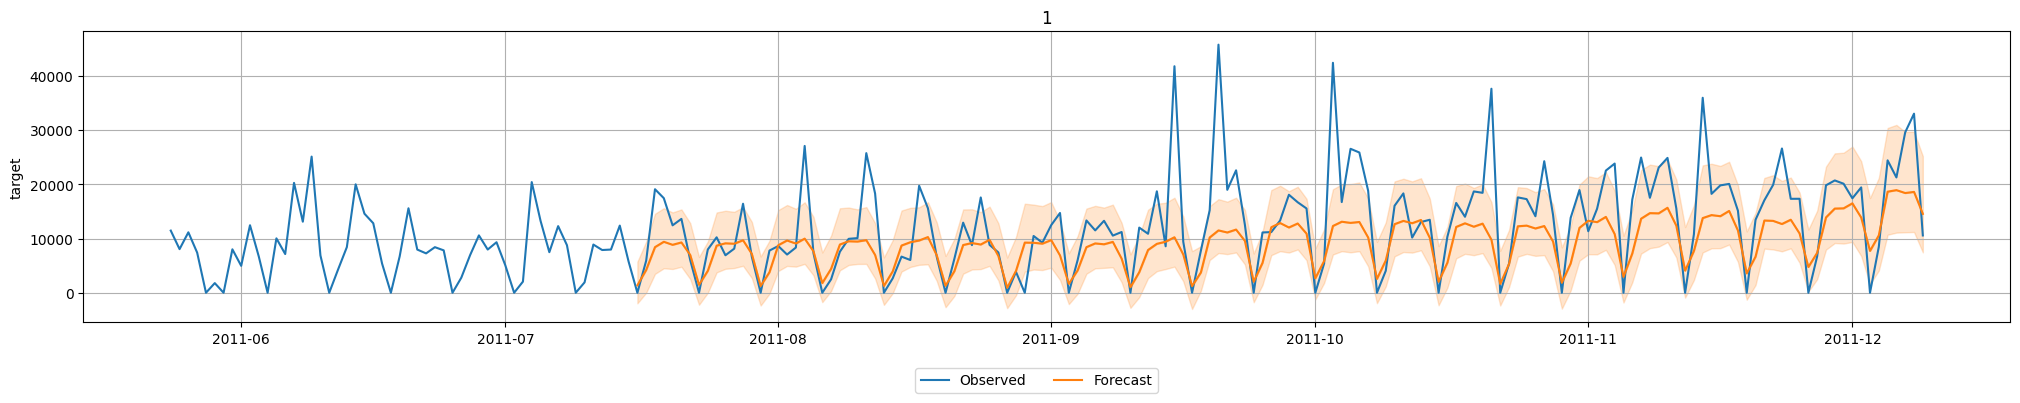

In [ ]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=total_sales_chronos,
    predictions=predictions,
    item_ids=total_sales_chronos.item_ids[:],
    max_history_length=200,
);

In [ ]:
# print(predictions.shape)
# predictions.head()

(147, 10)


mean           0.1           0.2           0.3  \
item_id timestamp                                                            
1       2011-07-16   2705.583008  -3443.806641  -1239.925781    273.917969   
        2011-07-17   9966.151367   1910.095703   4783.661133   6732.791992   
        2011-07-18  18878.332031   9566.096680  12610.142578  14919.750000   
        2011-07-19  21370.750000  12132.632812  15188.575195  17448.964844   
        2011-07-20  19879.322266  11594.318359  14329.102539  16365.175781   

                             0.4           0.5           0.6           0.7  \
item_id timestamp                                                            
1       2011-07-16   1556.593750   2705.583008   3930.724609   5363.379883   
        2011-07-17   8411.370117   9966.151367  11510.843750  13333.750977   
        2011-07-18  16940.664062  18878.332031  20793.576172  22962.683594   
        2011-07-19  19407.513672  21370.750000  23377.550781  25542.246094   
        2011-07-20  18096.048828  19879.322266  21765.201172  23815.728516   

                             0.8           0.9  
item_id timestamp                               
1       2011-07-16   7271.401367  10469.629883  
        2011-07-17  15655.492188  19457.615234  
        2011-07-18  25640.488281  30122.480469  
        2011-07-19  28211.128906  32581.179688  
        2011-07-20  26304.695312  30478.626953

In [ ]:
predictor.leaderboard(test_data, extra_metrics=['WQL','MAE', 'MSE','RMSE','MAPE'])

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order,WQL,MAE,MSE,RMSE,MAPE
0,Chronos[bolt_base],-0.319199,None,7.029202,None,0.042992,1,-0.319199,-5254.553783,-6.156489e+07,-7846.329492,-0.319659


In [ ]:
# test_data_pd = test_data.reset_index().set_index('timestamp')['target']
# # split test set into 3 equal regions

# def mape(y_true, y_pred):
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# def three_split_plot(predictions, subtitle = ""):

#     test_predict = predictions.reset_index().set_index('timestamp')['mean']
#     test_split = np.array_split(test_predict.index, 3)

#     mape_results = []

#     for i, period in enumerate(test_split):
#         mape_period = mape(test_data_pd.loc[period], test_predict.loc[period])
#         mape_results.append(mape_period)
#         print(f"Overall MAPE for Test Period {i+1}: {mape_period:.2f}%")

#     error_df = []
#     for i, period in enumerate(test_split):
#         period_error = test_data_pd.loc[period] - test_predict.loc[period]
#         error_df.append(pd.DataFrame({'Error': period_error, 'Test Period': f"Overall Period {i+1}"}))

#     error_df = pd.concat(error_df)

#     if subtitle: plt.suptitle(subtitle, fontsize=12)

#     plt.figure(figsize=(8,5))
#     sns.boxplot(x="Test Period", y="Error", data=error_df)
#     plt.title(subtitle + ": Overall Error Distribution Across Test Periods")
#     plt.xlabel("Test Period (Overall)")
#     plt.ylabel("Prediction Error")
#     plt.grid()
#     plt.show()

# three_split_plot(predictions, 'bolt_base Zero-shot')

## Chronos fine-tuned model

### Chronos fine tune bolt_small

#### manually set hyperparameters tuning

In [14]:
from autogluon.common import space

prediction_length = int(len(total_sales_chronos)*0.2)
train_data, test_data = total_sales_chronos.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length, eval_metric="MAPE").fit(
    train_data=train_data,
    hyperparameters = {
            "Chronos": [
                {"model_path": "bolt_small", "ag_args": {"name_suffix": "ZeroShot"}},
                {"model_path": "bolt_small", "fine_tune": True,
                 "fine_tune_lr": space.Real(0.000001, 0.001, log=True),
                 "fine_tune_steps": space.Categorical(125, 250, 500, 1000),
                 "fine_tune_batch_size": space.Categorical(16, 32, 64),
                 "ag_args": {"name_suffix": "FineTuned"}}
            ]
        },
    hyperparameter_tune_kwargs="auto", # this line allows hyperparameter space
    time_limit=1000,  # time limit in seconds
    # enable_ensemble=False,
)

Beginning AutoGluon training... Time limit = 1000s
AutoGluon will save models to '/content/drive/.shortcut-targets-by-id/1bsuuXsN9f_3_uPMxfoq1e9R2u7sIHJwZ/Online Retail/Chronos on Previous Categories/AutogluonModels/ag-20250425_003159'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
GPU Count:          0
Memory Avail:       11.15 GB / 12.67 GB (87.9%)
Disk Space Avail:   61.92 GB / 107.72 GB (57.5%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                 

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/191M [00:00<?, ?B/s]

	-0.3593       = Validation score (-MAPE)
	13.61   s     = Training runtime
	2.75    s     = Validation (prediction) runtime
Hyperparameter tuning model ChronosFineTuned[bolt_small]. Tuning model for up to 489.0s of the 978.0s remaining.
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/drive/.shortcut-targets-by-id/1bsuuXsN9f_3_uPMxfoq1e9R2u7sIHJwZ/Online Retail/Chronos on Previous Categories/AutogluonModels/ag-20250425_003159/models/ChronosFineTuned[bolt_small]/T1/W0/fine-tuned-ckpt
	Trained 1 models while tuning ChronosFineTuned[bolt_small].
	-0.4028       = Validation score (-MAPE)
	280.05  s     = Total tuning time
Fitting simple weighted ensemble.
	Ensemble weights: {'ChronosZeroShot[bolt_small]': 1.0}
	-0.3593       = Validation score (-MAPE)
	0.24    s     = Training runtime
	2.75    s     = Validation (prediction) runtime
Training complete. Models trained: ['ChronosZeroShot[bolt_small]', 'ChronosF

In [15]:
predictor.leaderboard(test_data, extra_metrics=['WQL', 'MAE', 'MSE','RMSE','MAPE'])

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order,WQL,MAE,MSE,RMSE,MAPE
0,ChronosFineTuned[bolt_small]/T1,-0.298614,-0.402795,1.317735,0.252484,279.482554,2,-0.288442,-4607.045008,-5.245345e+07,-7242.475204,-0.298614
1,WeightedEnsemble,-0.320139,-0.359312,1.080583,2.745547,0.242345,3,-0.318185,-5094.798294,-6.091623e+07,-7804.885200,-0.320139
2,ChronosZeroShot[bolt_small],-0.320139,-0.359312,1.075152,2.745547,13.614229,1,-0.318185,-5094.798294,-6.091623e+07,-7804.885200,-0.320139


Model not specified in predict, will default to the model with the best validation score: ChronosZeroShot[bolt_small]


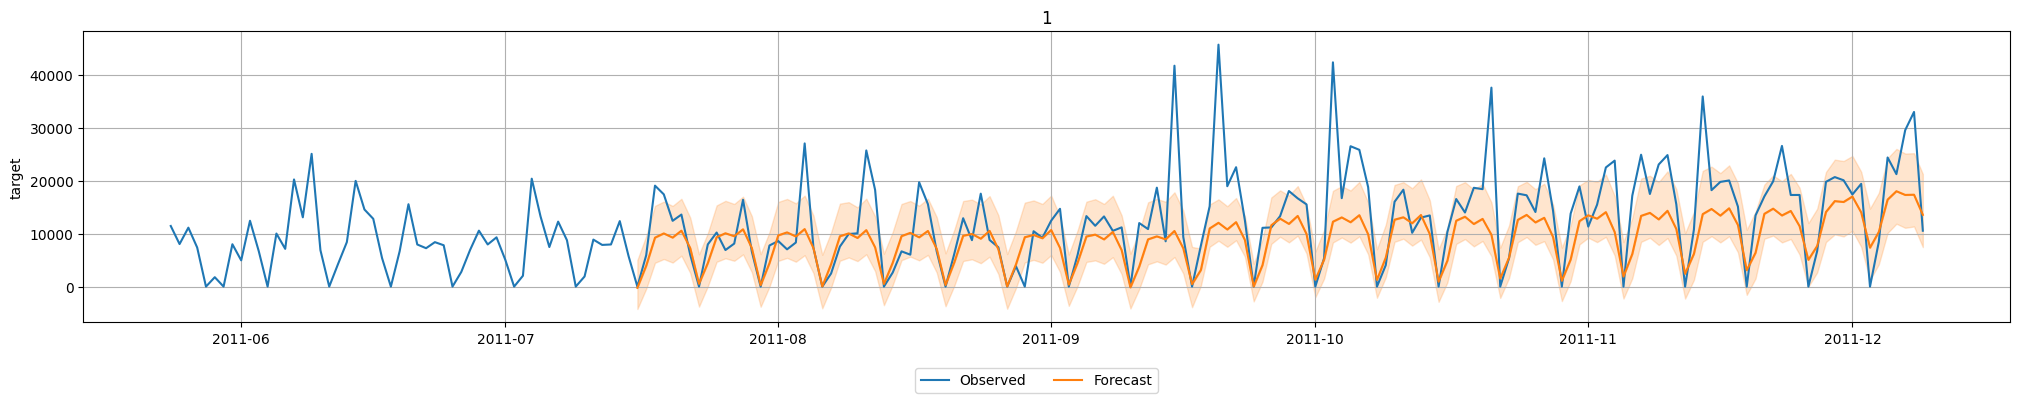

In [16]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=total_sales_chronos,
    predictions=predictions,
    item_ids=total_sales_chronos.item_ids[:],
    max_history_length=200,
);

### Chronos fine tune bolt_base

#### manually set hyperparameters tuning

In [17]:
from autogluon.common import space

prediction_length = int(len(total_sales_chronos)*0.2)
train_data, test_data = total_sales_chronos.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data=train_data,
    hyperparameters = {
            "Chronos": [
                {"model_path": "bolt_base", "ag_args": {"name_suffix": "ZeroShot"}},
                {"model_path": "bolt_base", "fine_tune": True,
                 "fine_tune_lr": space.Real(0.000001, 0.001, log=True),
                 "fine_tune_steps": space.Categorical(125, 250, 500, 1000),
                 "fine_tune_batch_size": space.Categorical(16, 32, 64),
                 "ag_args": {"name_suffix": "FineTuned"}}
            ]
        },
    hyperparameter_tune_kwargs="auto", # this line allows hyperparameter space
    time_limit=1200,  # time limit in seconds
    # enable_ensemble=False,
)

Beginning AutoGluon training... Time limit = 1200s
AutoGluon will save models to '/content/drive/.shortcut-targets-by-id/1bsuuXsN9f_3_uPMxfoq1e9R2u7sIHJwZ/Online Retail/Chronos on Previous Categories/AutogluonModels/ag-20250425_003825'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
GPU Count:          0
Memory Avail:       10.05 GB / 12.67 GB (79.3%)
Disk Space Avail:   61.54 GB / 107.72 GB (57.1%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_base'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                   

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/821M [00:00<?, ?B/s]

	-0.3047       = Validation score (-WQL)
	0.01    s     = Training runtime
	6.65    s     = Validation (prediction) runtime
Hyperparameter tuning model ChronosFineTuned[bolt_base]. Tuning model for up to 596.6s of the 1193.2s remaining.
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/drive/.shortcut-targets-by-id/1bsuuXsN9f_3_uPMxfoq1e9R2u7sIHJwZ/Online Retail/Chronos on Previous Categories/AutogluonModels/ag-20250425_003825/models/ChronosFineTuned[bolt_base]/T1/W0/fine-tuned-ckpt
	Trained 1 models while tuning ChronosFineTuned[bolt_base].
	-0.2988       = Validation score (-WQL)
	499.21  s     = Total tuning time
Fitting simple weighted ensemble.
	Ensemble weights: {'ChronosFineTuned[bolt_base]/T1': 0.96, 'ChronosZeroShot[bolt_base]': 0.04}
	-0.2988       = Validation score (-WQL)
	0.28    s     = Training runtime
	7.46    s     = Validation (prediction) runtime
Training complete. Models trained: ['Chro

In [18]:
predictor.leaderboard(test_data, extra_metrics=['WQL', 'MAE', 'MSE','RMSE','MAPE'])

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order,WQL,MAE,MSE,RMSE,MAPE
0,ChronosFineTuned[bolt_base]/T1,-0.288324,-0.298836,2.678475,0.812258,499.041229,2,-0.288324,-4675.368731,-5.285598e+07,-7270.211823,-0.295886
1,WeightedEnsemble,-0.289259,-0.298832,4.493444,7.464709,0.276597,3,-0.289259,-4693.548650,-5.312355e+07,-7288.590346,-0.296557
2,ChronosZeroShot[bolt_base],-0.319199,-0.304673,1.809670,6.652451,0.013858,1,-0.319199,-5254.553753,-6.156488e+07,-7846.329318,-0.319659


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


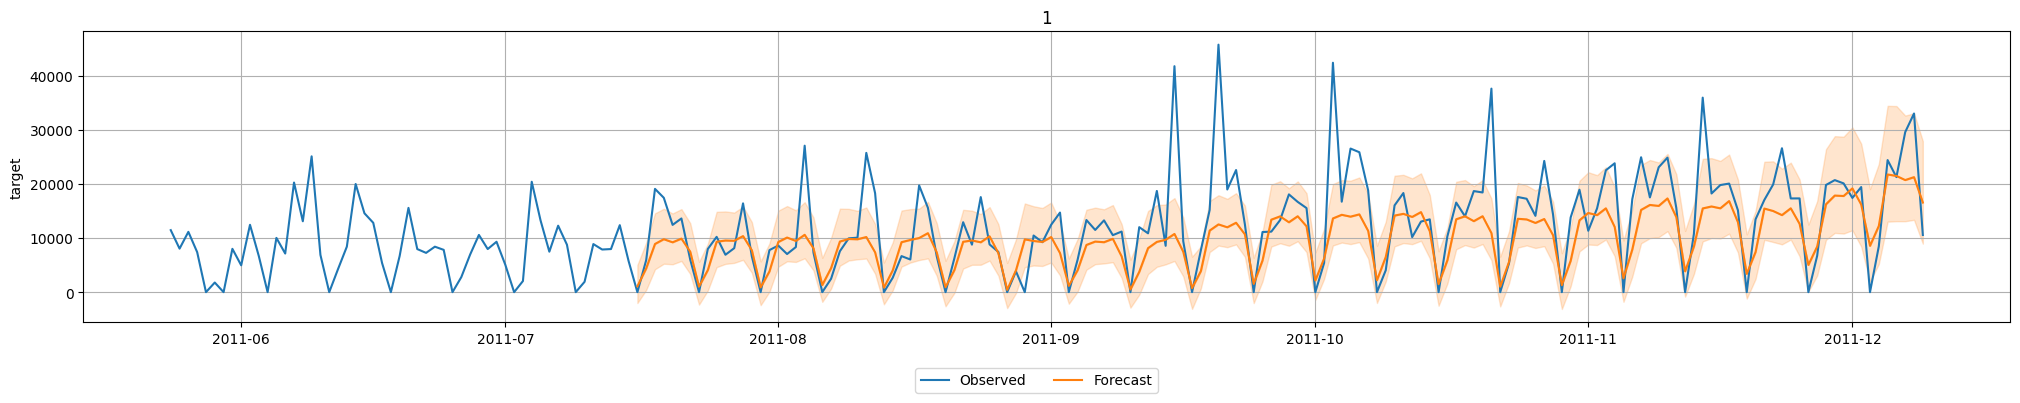

In [19]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=total_sales_chronos,
    predictions=predictions,
    item_ids=total_sales_chronos.item_ids[:],
    max_history_length=200,
);